In [1]:
import os
import sys
import numpy as np

import argparse

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from models import *

from torch.autograd import Variable

from differential_evolution import differential_evolution
import matplotlib

import matplotlib.pyplot as plt


import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)
densenet = models.densenet161(pretrained=True)
inception = models.inception_v3(pretrained=True)


C:\Users\man\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\models\squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)
C:\Users\man\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\models\squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(m.weight.data, mean=0.0, std=0.01)
C:\Users\man\AppData\Local\Continuum\anaconda3\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


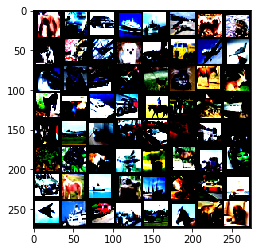

In [2]:

def imshow(img):
        # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def perturb_image(xs, img):
    if xs.ndim < 2:
        xs = np.array([xs])
    batch = len(xs)
    imgs = img.repeat(batch, 1, 1, 1)
    xs = xs.astype(int)

    count = 0
    for x in xs:
        pixels = np.split(x, len(x)/5)

        for pixel in pixels:
            x_pos, y_pos, r, g, b = pixel
            imgs[count, 0, x_pos, y_pos] = (r/255.0-0.4914)/0.2023
            imgs[count, 1, x_pos, y_pos] = (g/255.0-0.4822)/0.1994
            imgs[count, 2, x_pos, y_pos] = (b/255.0-0.4465)/0.2010
        count += 1

    return imgs

def predict_classes(xs, img, target_calss, net, minimize=True):
    imgs_perturbed = perturb_image(xs, img.clone())
#     input = Variable(imgs_perturbed, volatile=True).cuda()
    input = Variable(imgs_perturbed, volatile=True)
    predictions = F.softmax(net(input)).data.cpu().numpy()[:, target_calss]

    return predictions if minimize else 1 - predictions

def attack_success(x, img, target_calss, net, targeted_attack=False, verbose=False):

    attack_image = perturb_image(x, img.clone())
#     input = Variable(attack_image, volatile=True).cuda()
    input = Variable(attack_image, volatile=True)
    confidence = F.softmax(net(input)).data.cpu().numpy()[0]
    predicted_class = np.argmax(confidence)

    if (verbose):
        print( "Confidence: %.4f"%confidence[target_calss])
    if (targeted_attack and predicted_class == target_calss) or (not targeted_attack and predicted_class != target_calss):
        return True


def attack(img, label, net, target=None, pixels=1, maxiter=75, popsize=400, verbose=False):
    # img: 1*3*W*H tensor
    # label: a number

    targeted_attack = target is not None
    target_calss = target if targeted_attack else label

    bounds = [(0,32), (0,32), (0,255), (0,255), (0,255)] * pixels

    popmul = max(1, popsize/len(bounds))

    predict_fn = lambda xs: predict_classes(
        xs, img, target_calss, net, target is None)
    callback_fn = lambda x, convergence: attack_success(
        x, img, target_calss, net, targeted_attack, verbose)
    print(popmul*len(bounds))
    inits = np.zeros([int(popmul*len(bounds)), int(len(bounds))])
    print(inits)
    for init in inits:
        for i in range(pixels):
            init[i*5+0] = np.random.random()*32
            init[i*5+1] = np.random.random()*32
            init[i*5+2] = np.random.normal(128,127)
            init[i*5+3] = np.random.normal(128,127)
            init[i*5+4] = np.random.normal(128,127)

    attack_result = differential_evolution(predict_fn, bounds, maxiter=maxiter, popsize=popmul,
        recombination=1, atol=-1, callback=callback_fn, polish=False, init=inits)

    attack_image = perturb_image(attack_result.x, img)
    
#     attack_var = Variable(attack_image, volatile=True).cuda()
    attack_var = Variable(attack_image, volatile=True)
    print(attack_image)
    imshow(torchvision.utils.make_grid(attack_image))
    predicted_probs = F.softmax(net(attack_var)).data.numpy()[0]

    predicted_class = np.argmax(predicted_probs)

    if (not targeted_attack and predicted_class != label) or (targeted_attack and predicted_class == target_calss):
        return 1, attack_result.x.astype(int)
    return 0, [None]


def attack_all(net, loader, pixels=1, targeted=False, maxiter=75, popsize=400, verbose=False):

    correct = 0
    success = 0

    for batch_idx, (input, target) in enumerate(loader):

        #img_var = Variable(input, volatile=True).cuda()
        
        img_var = Variable(input, volatile=True)
        #print(img_var.shape)
        prior_probs = F.softmax(net(img_var))
        _, indices = torch.max(prior_probs, 1)

        if target[0] != indices.data.cpu()[0]:
            continue

        correct += 1
        target = target.numpy()

        targets = [None] if not targeted else range(10)

        for target_calss in targets:
            if (targeted):
                if (target_calss == target[0]):
                    continue

            flag, x = attack(input, target[0], net, target_calss, pixels=pixels, maxiter=maxiter, popsize=popsize, verbose=verbose)

            success += flag
            if (targeted):
                success_rate = float(success)/(9*correct)
            else:
                success_rate = float(success)/correct

            if flag == 1:
                print( "success rate: %.4f (%d/%d) [(x,y) = (%d,%d) and (R,G,B)=(%d,%d,%d)]"%(success_rate, success, correct, x[0],x[1],x[2],x[3],x[4]))

        if correct == args.samples:
            break

    return success_rate


def cifar_loaders(batch_size, shuffle_test=False): 
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.225, 0.225, 0.225])
    train = datasets.CIFAR10('./', train=True, download=True, 
        transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]))
    test = datasets.CIFAR10('./', train=False, 
        transform=transforms.Compose([transforms.ToTensor(), normalize]))
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size,
        shuffle=True, pin_memory=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size,
        shuffle=shuffle_test, pin_memory=True)
    return train_loader, test_loader

  
batch_size = 64
test_batch_size = 64

train_loader, _ = cifar_loaders(batch_size)
_, test_loader = cifar_loaders(test_batch_size)



classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


# get some random training 1 batch -- 64
dataiter = iter(train_loader)
imagesR, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(imagesR))

assert os.path.isdir('networks'), 'Error: no checkpoint directory found!'

In [3]:
#normalize = transforms.Normalize(mean=[0.99, 0.456, 0.406],
                                     #std=[0.225, 0.225, 0.225])
#(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)
tranfrom_test = transforms.Compose([transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.225, 0.224, 0.225)),
    ])
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=tranfrom_test)
testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True, num_workers=2)

plane


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


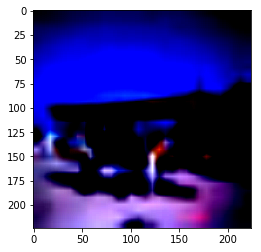

tensor([[[[-1.9290, -1.9290, -1.9290,  ..., -2.0161, -2.0161, -2.0161],
          [-1.9290, -1.9290, -1.9290,  ..., -2.0161, -2.0161, -2.0161],
          [-1.9290, -1.9290, -1.9290,  ..., -2.0161, -2.0161, -2.0161],
          ...,
          [ 0.1277,  0.1277,  0.1277,  ..., -0.3603, -0.3603, -0.3603],
          [ 0.1277,  0.1277,  0.1277,  ..., -0.3603, -0.3603, -0.3603],
          [ 0.1277,  0.1277,  0.1277,  ..., -0.3603, -0.3603, -0.3603]],

         [[-1.2654, -1.2654, -1.2654,  ..., -1.5280, -1.5280, -1.5280],
          [-1.2654, -1.2654, -1.2654,  ..., -1.5280, -1.5280, -1.5280],
          [-1.2654, -1.2654, -1.2654,  ..., -1.5280, -1.5280, -1.5280],
          ...,
          [ 0.0476,  0.0476,  0.0476,  ..., -0.5301, -0.5301, -0.5301],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.5301, -0.5301, -0.5301],
          [ 0.0476,  0.0476,  0.0476,  ..., -0.5301, -0.5301, -0.5301]],

         [[ 0.0082,  0.0082,  0.0082,  ..., -0.2707, -0.2707, -0.2707],
          [ 0.0082,  0.0082,  

In [14]:
# get some random training 1 batch -- 64
dataiter = iter(testloader)
imagesR, labels = dataiter.next()
print(classes[labels.item()])
# print(classes(Variable(labels).item()))
imshow(torchvision.utils.make_grid(imagesR))
print(imagesR)
#results = attack_all(vgg16, testloader, pixels=1, targeted=False, maxiter=60, popsize=400, verbose=False)
# newoutput=attack(img=imagesR, label= 4, net=vgg16, target=None, pixels=1, maxiter=30, popsize=1, verbose=False)

In [ ]:
pixeltest=np.array([200, 100, 255, 255, 255])
attack_image = perturb_image( ( pixeltest), imagesR)

imshow(torchvision.utils.make_grid(attack_image))

attack_var = Variable(attack_image, volatile=True)
  

predicted_probs2 = F.softmax(vgg16(attack_var)).data.numpy()[0]

predicted_class2 = np.argmax(predicted_probs2)


predicted_probs = F.softmax(resnet(imagesR)).data.numpy()[0]
predicted_class = np.argmax(predicted_probs)
print(predicted_class)
print(predicted_class2)